In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# setup parsl

This code sets parsl resources

In [3]:
import IMLCV

from IMLCV.configs.config_general import config
config(    local_ref_threads  = 2 )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


node
local


# make MD simulations for alanine dipeptide in 2 stable minima

In [7]:
from IMLCV.examples.example_systems import alanine_dipeptide_refs
from IMLCV.examples.example_systems import alanine_dipeptide_yaff
from IMLCV.implementations.CV import NoneCV
from IMLCV.base.rounds import Rounds
from IMLCV.base.bias import NoneBias


from pathlib import Path

folder = Path("alanine_dipeptide_LDA")

if not folder.exists():

    lda_steps = 1e4

    mde = alanine_dipeptide_yaff()
    refs = alanine_dipeptide_refs()

    rnds = Rounds(folder=folder)
    rnds.add_cv_from_cv(cv=NoneCV())
    rnds.add_round_from_md(mde)

    biases = []
    for _ in refs:
        biases.append(NoneBias(cvs=NoneCV()))

    rnds.run_par(biases=biases, steps=lda_steps, sp0=refs, plot=False)
else:
    rnds = Rounds(folder=folder, new_folder=False)

# discover new CV with LDA between phases

In [8]:
from IMLCV.scheme import Scheme
scheme0 = Scheme.from_rounds(rnds)

Loading MD engine
setting filename=None


starting pre_fit
starting fit
starting post_fit


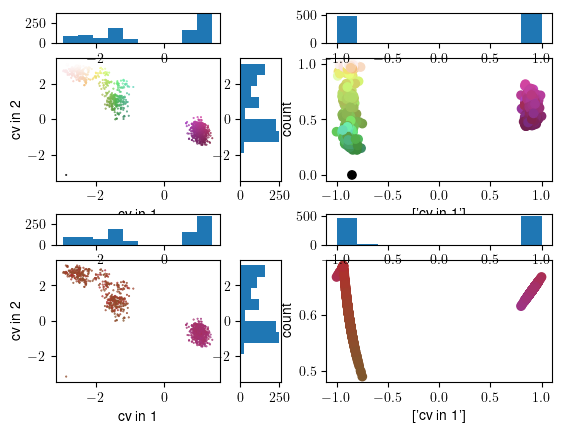

In [10]:


from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.CvDiscovery import TransoformerLDA
from IMLCV.implementations.CV import sb_descriptor

from molmod.units import angstrom
   


out_dim = 1
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)
tf = TransoformerLDA(outdim=out_dim , descriptor=descriptor)

scheme0.update_CV(
    samples=1e3,
    split_data=True,
    cvd=CVDiscovery(transformer=tf),
    new_r_cut=r_cut,
    chunk_size=300,
    alpha_rematch=0.05,
    plot=True,
    pre_scale=False,
    sort="rematch",
)


# do new MD run with discovered CV

In [16]:
from molmod.units import kjmol

scheme0.inner_loop( rnds=3, n=4,steps=1000, init=500, plot=True)

running init round with 500 steps
Loading MD engine
new point got cv=None, e_pot=None and new bias 0.393479598811746 
new point got cv=None, e_pot=None and new bias 12.847324078308539 
new point got cv=None, e_pot=None and new bias 60.77624903349331 
new point got cv=None, e_pot=None and new bias 144.18025446436613 
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.92160289]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-7.58302972] and new bias 0.24528784312973964 
new point got cv=CV(cv=array([[-0.90425351]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[0.73203679] and new bias 13.008484104237455 
new point got cv=CV(cv=array([[-0.77797389]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-4.64310037] and new bias 49.288339804550255 
new point got cv=CV(cv=array([[-0.63059114]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[40.88069526]

lets look at the umbrella simulations and the produced Free energy surface

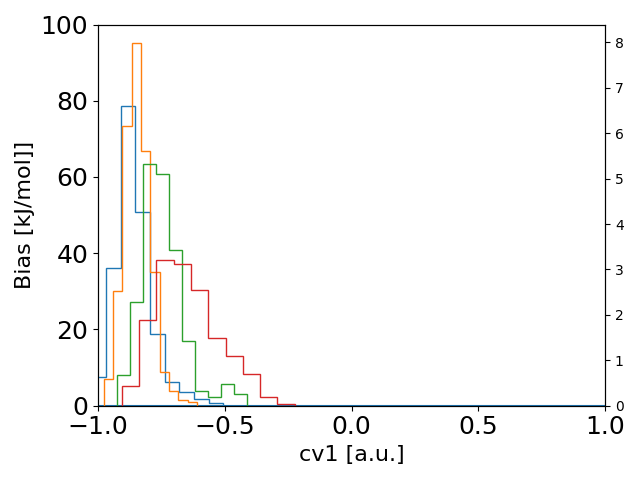

In [25]:
from IPython.display import IFrame
from IPython.display import Image
Image(  folder/"cv_1"/"round_1"/"combined.png" )


Clearly, the umbrellas stay in the same phase (because they were all started from the same seed). The generated free energy surface tries to compensate:



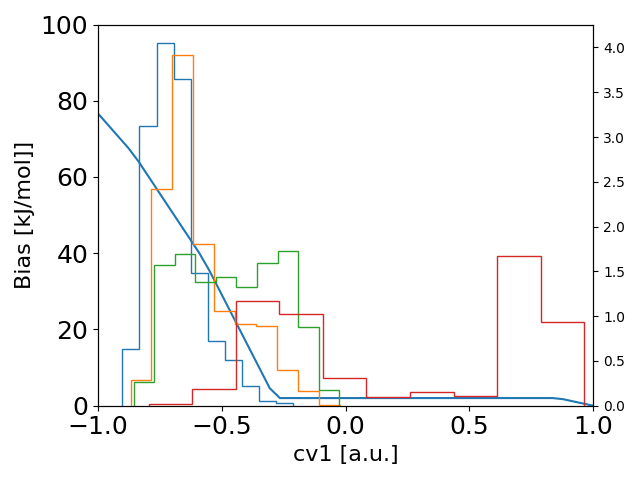

In [20]:
Image(  folder/"cv_1"/"round_2"/"combined.png" )

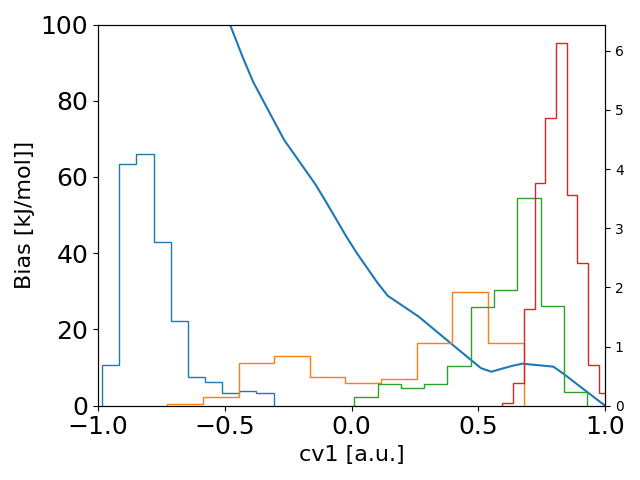

In [21]:
Image(  folder/"cv_1"/"round_3"/"combined.png" )

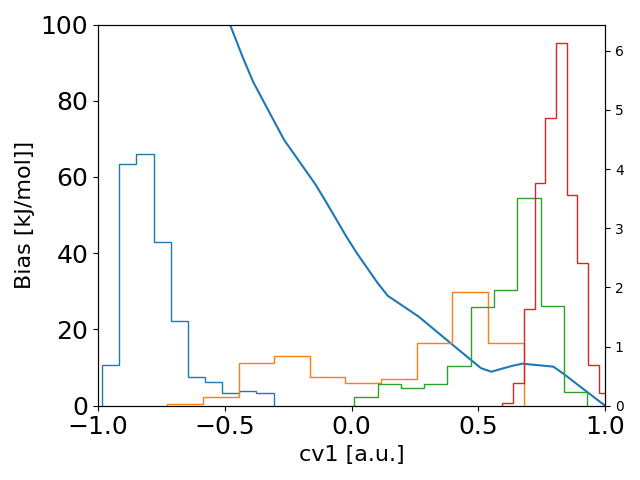

In [22]:
Image(  folder/"cv_1"/"round_3"/"combined.png" )

clearly, the umbrellas do not uniformly cover the space yet, hence more simulations are needed


In [32]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True)

running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.5733971]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[98.63807068] and new bias 7.263125068787482 
new point got cv=CV(cv=array([[-0.43159576]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[45.12364562] and new bias 0.38534605907860914 
new point got cv=CV(cv=array([[0.55898699]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[15.26303079] and new bias 2.0321729351181816 
new point got cv=CV(cv=array([[0.571631]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[1.88967389] and new bias 7.32338697041011 
Loading MD engine
setting bias=<IMLCV.implementations.bias.GridBias object at 0x7f8185e0ba60>
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.21756819]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[78.4759501] and new bias 24.4

let's look at the coverage and convergence

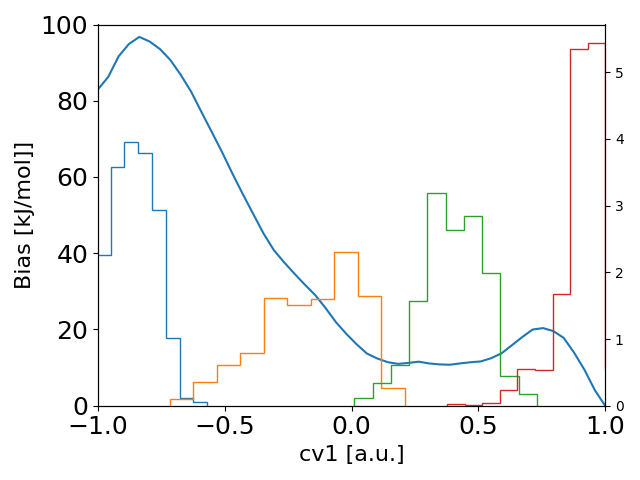

In [37]:
from IPython.display import Image

fig = Image(filename= folder/"cv_1"/"round_6"/"combined.png" )
fig

The umbrellas mmore or less cover the CV range, let's check if the FES has converged

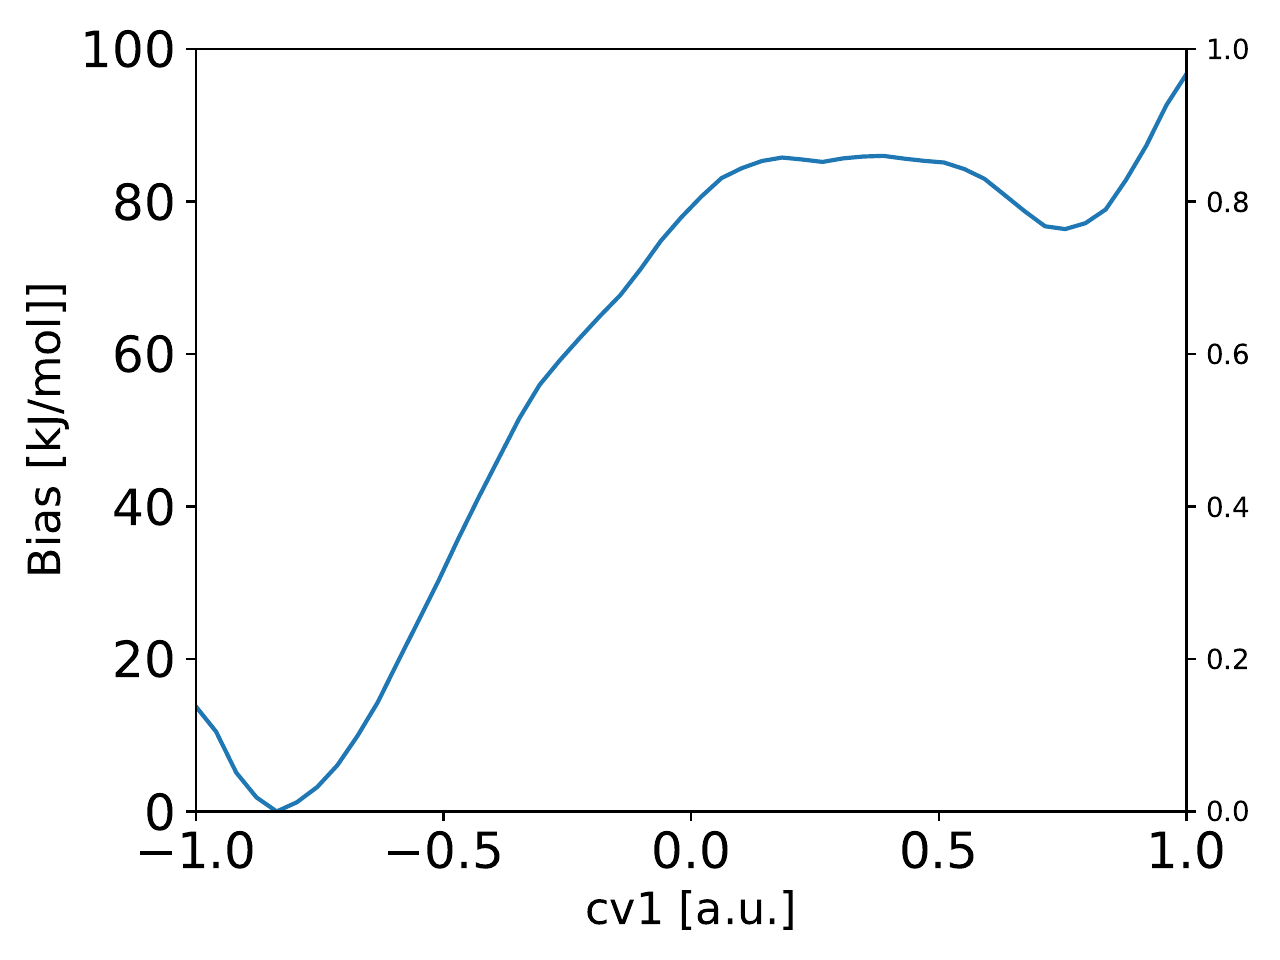

In [56]:
from pdf2image import convert_from_path

convert_from_path(folder/"cv_1"/"FES_bias_5_inverted_gridbias.pdf")[0]


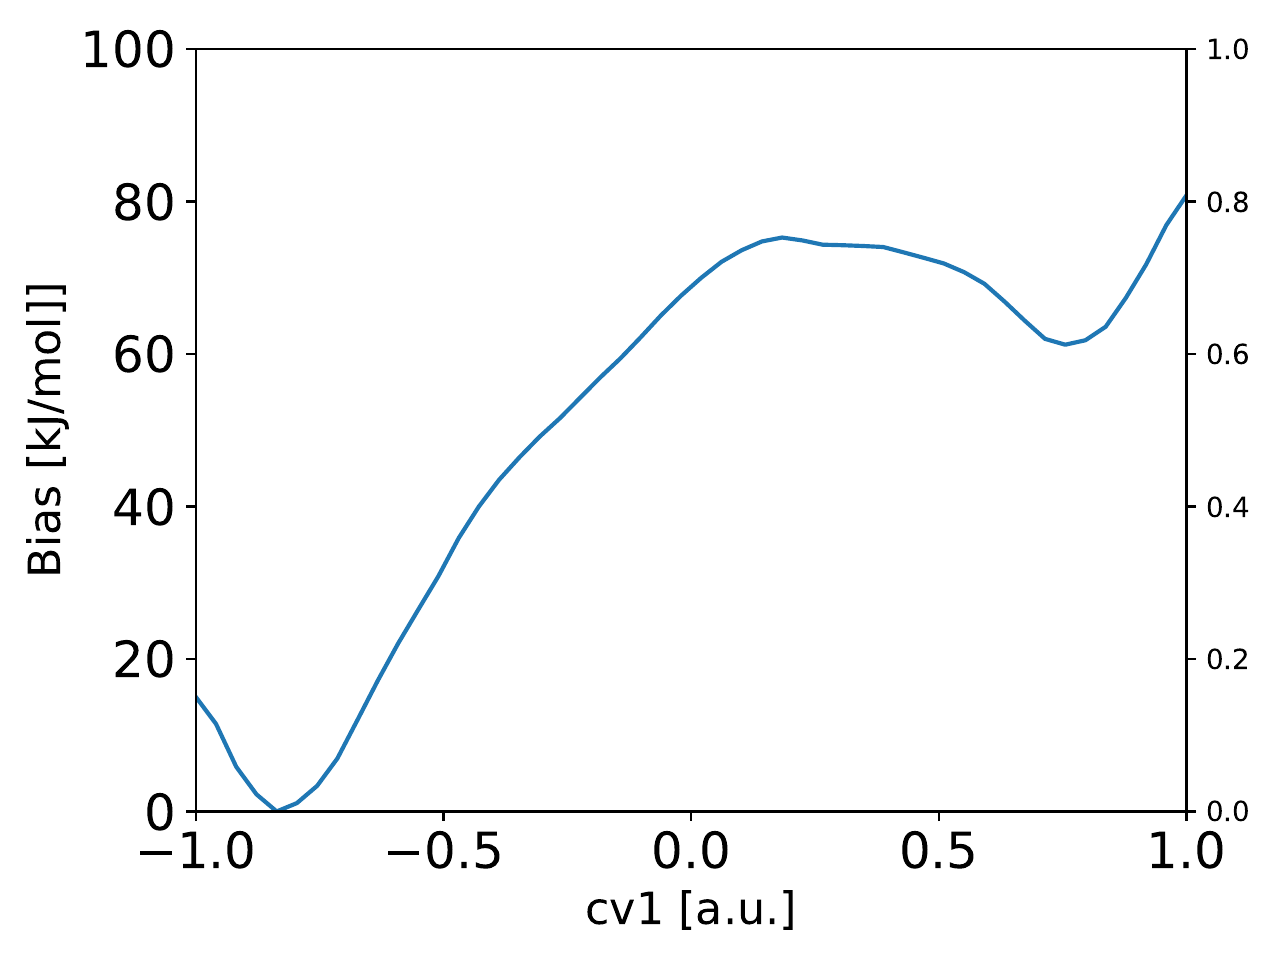

In [57]:
convert_from_path(folder/"cv_1"/"FES_bias_6_inverted_gridbias.pdf")[0]

The FES has not converged yet, so more samping is needed

In [58]:
scheme0.inner_loop( rnds=3, n=4,steps=1000, init=0, plot=True)

running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.66854722]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[7.28265989] and new bias 4.384491684502823 
new point got cv=CV(cv=array([[-0.67800279]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[49.24556706] and new bias 4.741126205845682 
new point got cv=CV(cv=array([[0.17493316]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[28.17761697] and new bias 1.0013530041190866 
new point got cv=CV(cv=array([[0.92866266]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[16.09948965] and new bias 0.20309992158075915 
Loading MD engine
setting bias=<IMLCV.implementations.bias.GridBias object at 0x7f80cee2a680>
running round with 1000 steps
Loading MD engine
new point got cv=CV(cv=array([[-0.82043008]]), mapped=False, atomic=False, _combine_dims=None, _stack_dims=None), e_pot=[-12.34847118] and new bia

Now we'll compare the FES again for round 8 and 9

/home/david/Documents/Projects/IMLCV/.micromamba/envs/default/lib/python3.10/site-packages/jax/_src/api_util.py:229: SyntaxWarning: Jitted function has invalid argnames {'mode'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


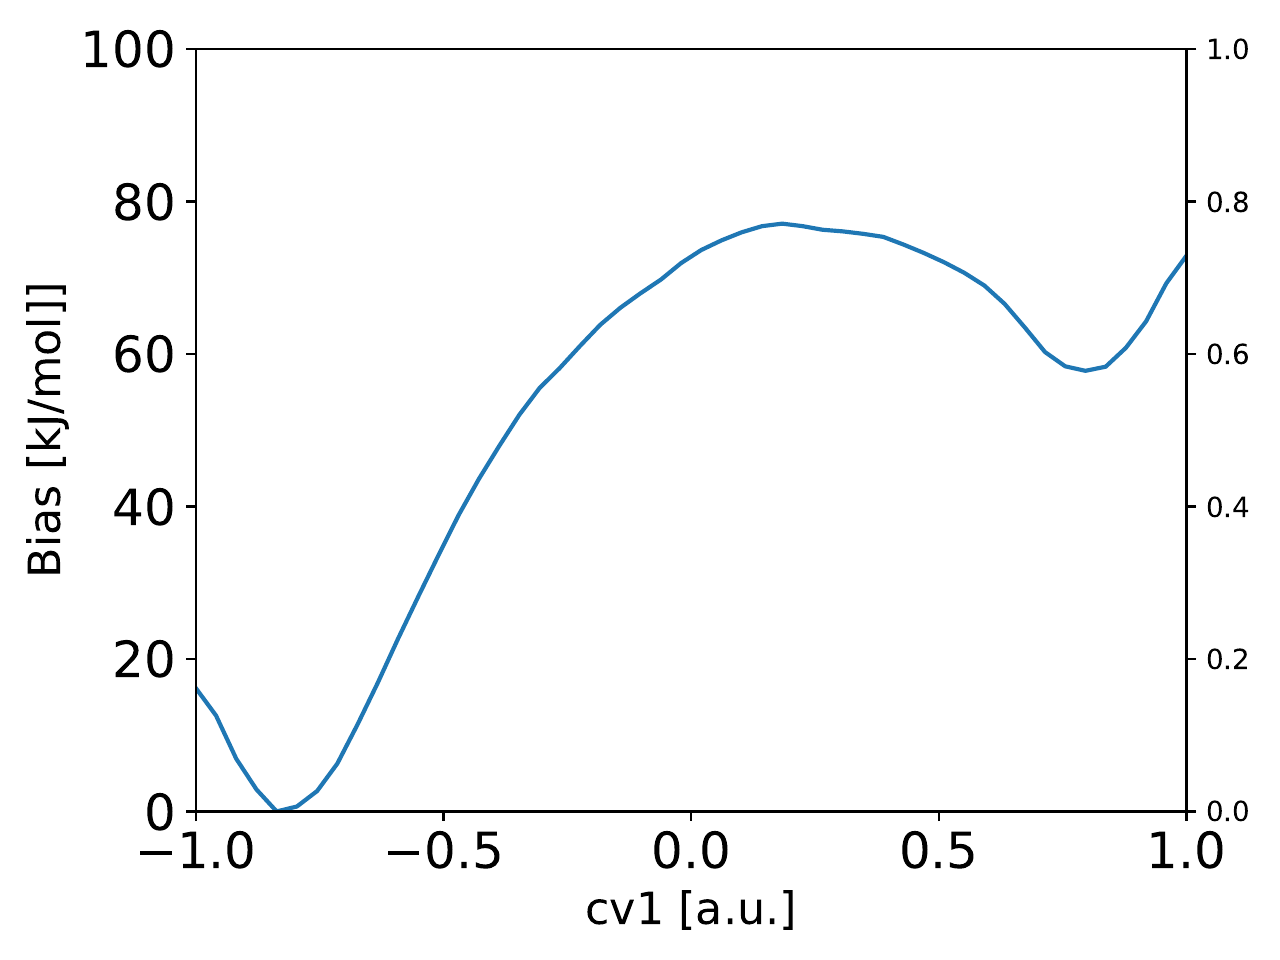

In [59]:
convert_from_path(folder/"cv_1"/"FES_bias_8_inverted_gridbias.pdf")[0]

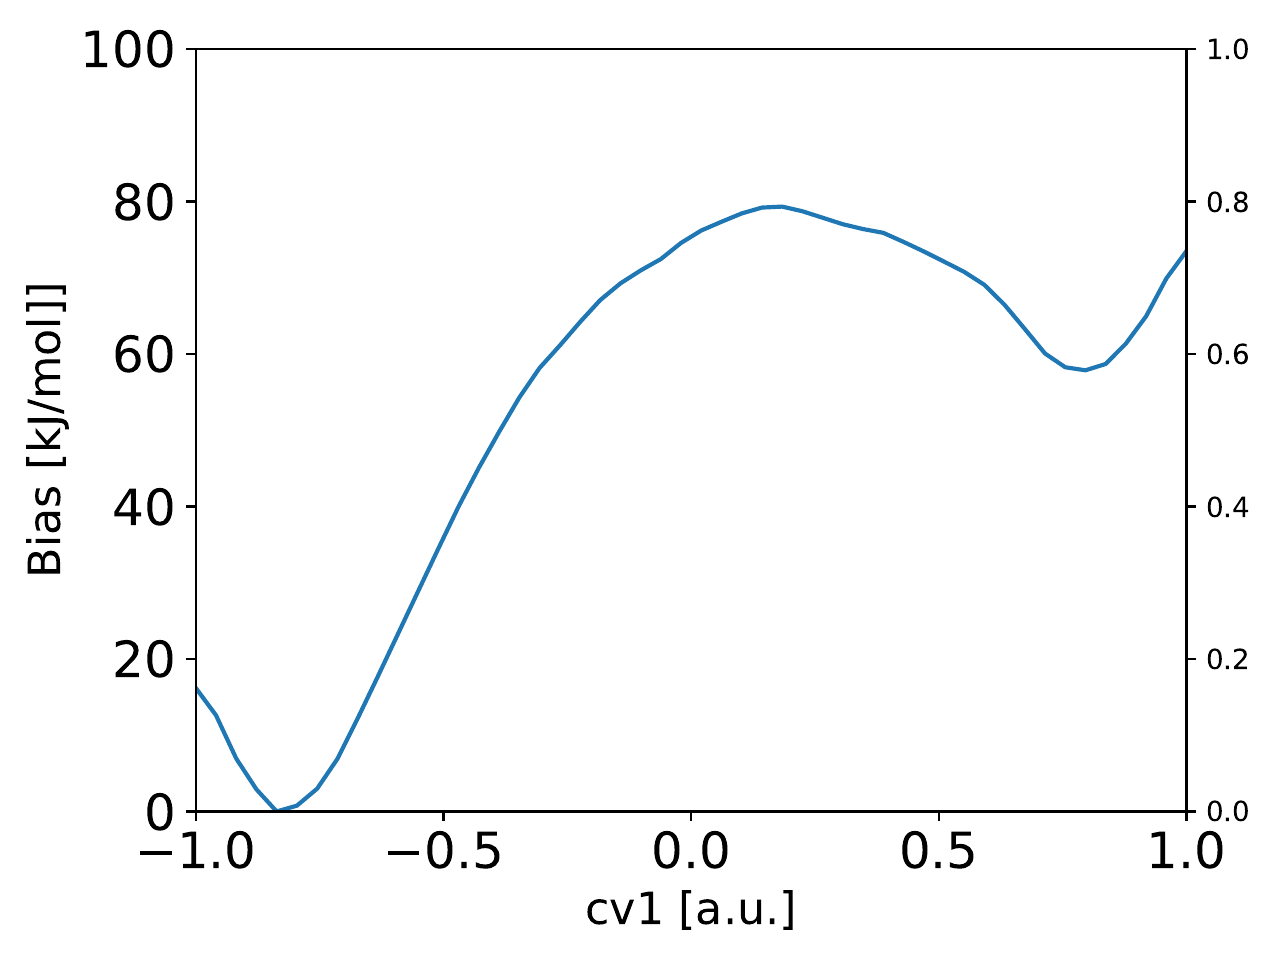

In [60]:
convert_from_path(folder/"cv_1"/"FES_bias_9_inverted_gridbias.pdf")[0]

# look for new CV wiht UMAP

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting pre_fit


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting fit


/home/david/Documents/Projects/IMLCV/.micromamba/envs/default/lib/python3.10/site-packages/umap/parametric_umap.py:375: UserWarning: Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
  warn(


Epoch 1/10


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


272/451 [=================>............] - ETA: 2s - loss: 0.3780 - reconstruction_loss: 0.0935 - umap_loss: 0.2846

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 9s 15ms/step - loss: 0.3415 - reconstruction_loss: 0.0809 - umap_loss: 0.2606
Epoch 2/10
159/451 [=========>....................] - ETA: 4s - loss: 0.2762 - reconstruction_loss: 0.0586 - umap_loss: 0.2177

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2733 - reconstruction_loss: 0.0572 - umap_loss: 0.2161
Epoch 3/10
 51/451 [==>...........................] - ETA: 6s - loss: 0.2695 - reconstruction_loss: 0.0554 - umap_loss: 0.2141

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


395/451 [=========================>....] - ETA: 0s - loss: 0.2683 - reconstruction_loss: 0.0545 - umap_loss: 0.2138

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2679 - reconstruction_loss: 0.0544 - umap_loss: 0.2136
Epoch 4/10
283/451 [=================>............] - ETA: 2s - loss: 0.2639 - reconstruction_loss: 0.0527 - umap_loss: 0.2112

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 14ms/step - loss: 0.2640 - reconstruction_loss: 0.0524 - umap_loss: 0.2116
Epoch 5/10
179/451 [==========>...................] - ETA: 3s - loss: 0.2628 - reconstruction_loss: 0.0511 - umap_loss: 0.2118

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2620 - reconstruction_loss: 0.0506 - umap_loss: 0.2113
Epoch 6/10
 65/451 [===>..........................] - ETA: 5s - loss: 0.2603 - reconstruction_loss: 0.0496 - umap_loss: 0.2107

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


414/451 [==========================>...] - ETA: 0s - loss: 0.2597 - reconstruction_loss: 0.0491 - umap_loss: 0.2106

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2596 - reconstruction_loss: 0.0491 - umap_loss: 0.2105
Epoch 7/10
313/451 [===================>..........] - ETA: 1s - loss: 0.2578 - reconstruction_loss: 0.0482 - umap_loss: 0.2096

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2578 - reconstruction_loss: 0.0481 - umap_loss: 0.2097
Epoch 8/10
209/451 [============>.................] - ETA: 3s - loss: 0.2565 - reconstruction_loss: 0.0474 - umap_loss: 0.2091

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2565 - reconstruction_loss: 0.0472 - umap_loss: 0.2093
Epoch 9/10
102/451 [=====>........................] - ETA: 5s - loss: 0.2551 - reconstruction_loss: 0.0468 - umap_loss: 0.2083

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


448/451 [============================>.] - ETA: 0s - loss: 0.2556 - reconstruction_loss: 0.0466 - umap_loss: 0.2090

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 7s 15ms/step - loss: 0.2556 - reconstruction_loss: 0.0466 - umap_loss: 0.2090
Epoch 10/10
345/451 [=====================>........] - ETA: 1s - loss: 0.2550 - reconstruction_loss: 0.0462 - umap_loss: 0.2088

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


451/451 [==============================] - 6s 14ms/step - loss: 0.2548 - reconstruction_loss: 0.0462 - umap_loss: 0.2086


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread


starting post_fit


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strateg

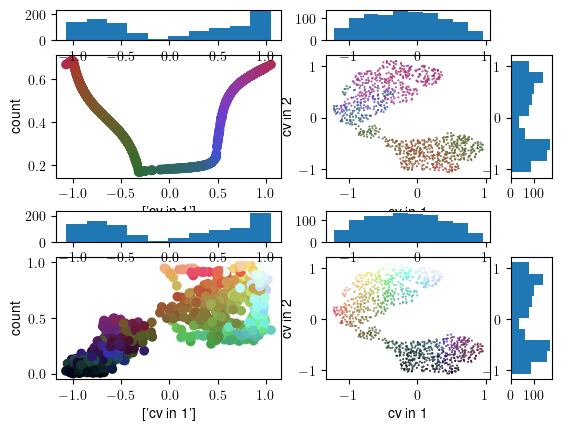

In [7]:
from IMLCV.base.CVDiscovery import CVDiscovery
from IMLCV.implementations.tensorflow.CvDiscovery import TranformerUMAP
from IMLCV.implementations.CV import sb_descriptor
from tensorflow import keras

from molmod.units import angstrom
   


out_dim = 2
r_cut = 4.0 * angstrom


descriptor = sb_descriptor(r_cut=r_cut, n_max=2, l_max=2, reshape=True)


tf = TranformerUMAP(outdim=out_dim, descriptor=descriptor)


cvd = CVDiscovery(
    transformer=tf,
)


scheme0.update_CV(
        samples=1e3,
        cvd=cvd,
        new_r_cut=r_cut,
        chunk_size=300,
        n_neighbors=40,
        min_dist=0.8,
        nunits=50,
        nlayers=2,
        metric="l2",
        densmap=False,
        parametric_reconstruction=True,
        parametric_reconstruction_loss_fcn=keras.losses.MSE,
        decoder=True,
    
)

# compare with backbone dihedral angles

For alanine dipeptide, the most well-known CVs are the so called backbone dihedral angles. We'll compare them here with our UMAP CVs

In [20]:
 %reload_ext autoreload

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strateg

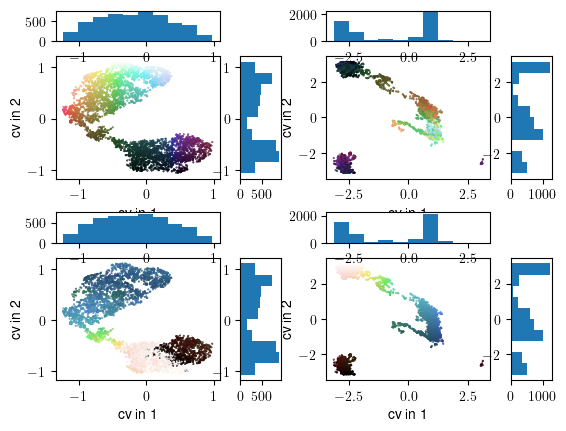

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.strategy:general strateg

In [15]:
from IMLCV.base.CV import CollectiveVariable,CvMetric
from IMLCV.implementations.CV import dihedral
import numpy as np
from IMLCV.base.CVDiscovery import CVDiscovery

bd_cv0 = CollectiveVariable(
    f=(dihedral(numbers=[4, 6, 8, 14]) + dihedral(numbers=[6, 8, 14, 16])),
    metric=CvMetric(
        periodicities=[True, True],
        bounding_box=[[-np.pi, np.pi], [-np.pi, np.pi]],
    ),
)

umap_cv = scheme0.md.bias.collective_variable

sp,nl,cv,sti =  CVDiscovery.data_loader(  scheme0.rounds,out=5e3,new_r_cut= scheme0.md.static_trajectory_info.r_cut  ,cv_round=1      )


CVDiscovery.plot_app(  name= folder/"cv_2"/"comp_bd.pdf",  sps=  sp[0] ,   nl=  nl[0],   old_cv=umap_cv, new_cv=bd_cv0, chunk_size=300)

The clustering is clearly very similar, and the 2 main part are separated by a narrow passage. Both structures follow the same passage. It is clear that not the full sphase space hase been discovered yet, so we perform new umbralla sampling with the UMAP CV

In [16]:

scheme0.inner_loop( rnds=3, n=4,steps=1000, init=500, plot=True)

running init round with 500 steps


Loading MD engine


DEBUG:parsl.dataflow.dflow:Task 0 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10864eb60 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108631180 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108631180 url=/home/david/Documents/Proj

new point got cv=None, e_pot=None and new bias 61.32710647583008 


DEBUG:parsl.dataflow.dflow:Task 4 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108527340 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1085aca60 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1085aca60 url=/home/david/Documents/Proj

new point got cv=None, e_pot=None and new bias 68.84111022949219 


DEBUG:parsl.app.futures:Creating DataFuture with parent: <AppFuture at 0x7fa10864c070 state=pending> and file: <File at 0x7fa1083e3af0 url=alanine_dipeptide_LDA/cv_2/round_0/md_1/plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_1/plot.pdf filename=plot.pdf>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10857bcd0 url=alanine_dipeptide_LDA/cv_2/round_0/md_1/plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_1/plot.pdf filename=plot.pdf>
INFO:parsl.dataflow.dflow:Task 7 submitted for App plot_app_load, waiting on task 6, task 6
DEBUG:parsl.dataflow.dflow:Task 7 set to pending state with AppFuture: <AppFuture at 0x7fa10864c070 state=pending>
DEBUG:parsl.dataflow.dflow:Task 7 has outstanding dependencies, so launch_if_ready skipping


DEBUG:parsl.dataflow.dflow:Task 8 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10864ded0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10855d6f0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10855d6f0 url=/home/david/Documents/Proj

new point got cv=None, e_pot=None and new bias 111.83019256591797 


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.dflow:Task 12 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108759210 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa298506e90 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_pro

new point got cv=None, e_pot=None and new bias 190.29434204101562 


DEBUG:parsl.dataflow.dflow:Task 16 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa118421cc0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1082a2230 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1082a2230 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 13.898341178894043 


DEBUG:parsl.app.futures:Creating DataFuture with parent: <AppFuture at 0x7fa1082178e0 state=pending> and file: <File at 0x7fa108216fb0 url=alanine_dipeptide_LDA/cv_2/round_0/md_4/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_4/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1083e6e60 url=alanine_dipeptide_LDA/cv_2/round_0/md_4/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_4/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
INFO:parsl.dataflow.dflow:Task 18 submitted for App plot_app, waiting on task 17, task 17
DEBUG:parsl.dataflow.dflow:Task 18 set to pending state with AppFuture: <AppFuture at 0x7fa1082178e0 state=pending>
DEBUG:parsl.dataflow.dflow:Task 18 has outstanding depende

DEBUG:parsl.dataflow.dflow:Task 20 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa1085ae200 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1187b7550 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1187b7550 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 21.41234016418457 


DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1082481c0 url=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf filename=plot.pdf>
DEBUG:parsl.dataflow.dflow:No stageout dependency for <File at 0x7fa118421cc0 url=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf filename=plot.pdf>
DEBUG:parsl.app.futures:Creating DataFuture with parent: <AppFuture at 0x7fa1082d0a30 state=pending> and file: <File at 0x7fa118421cc0 url=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_5/plot.pdf filename=plot.pdf>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File a

DEBUG:parsl.dataflow.dflow:Task 24 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108687df0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108666ef0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108666ef0 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 64.40142059326172 


DEBUG:parsl.dataflow.dflow:Task 28 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108139d50 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10812faf0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10812faf0 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 142.86558532714844 


DEBUG:parsl.app.futures:Creating DataFuture with parent: <parsl.app.futures.DataFuture object at 0x7fa1081382b0 representing <File at 0x7fa108596fe0 url=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf filename=bash_app_plot.pdf> not done> and file: <File at 0x7fa1082843a0 url=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1082843a0 url=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_7/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.da

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.dflow:Task 32 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10860d5a0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108106830 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_pro

new point got cv=None, e_pot=None and new bias 1.9446583986282349 


DEBUG:parsl.dataflow.dflow:Task 36 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108633df0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10825eaa0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa10825eaa0 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 9.458658218383789 


DEBUG:parsl.app.futures:Creating DataFuture with parent: <AppFuture at 0x7fa1081f2f80 state=pending> and file: <File at 0x7fa1081b92a0 url=alanine_dipeptide_LDA/cv_2/round_0/md_9/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_9/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1082a0250 url=alanine_dipeptide_LDA/cv_2/round_0/md_9/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_9/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
INFO:parsl.dataflow.dflow:Task 38 submitted for App plot_app, waiting on task 37, task 37
DEBUG:parsl.dataflow.dflow:Task 38 set to pending state with AppFuture: <AppFuture at 0x7fa1081f2f80 state=pending>
DEBUG:parsl.dataflow.dflow:Task 38 has outstanding depende

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.dflow:Task 40 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10824b790 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108287b20 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_pro

new point got cv=None, e_pot=None and new bias 52.44773864746094 


DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6b2a10 url=alanine_dipeptide_LDA/cv_2/round_0/md_10 scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_10 filename=md_10>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6b2a10 url=alanine_dipeptide_LDA/cv_2/round_0/md_10 scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_10 filename=md_10>
DEBUG:parsl.dataflow.dflow:Adding output dependencies
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa0bc6b06a0 url=alanine_dipeptide_LDA/cv_2/round_0/md_10/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_10/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.dataflow.dflow:Submitting stage out for output file <File at 0x7fa0bc6b06a0 url=alanine_dipeptide_LDA/cv_2/round_0/md_10/bash_app_plot.pdf schem

DEBUG:parsl.dataflow.dflow:Task 44 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10812fdc0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108285120 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa108285120 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 130.91189575195312 


DEBUG:parsl.dataflow.dflow:Submitting stage out for output file <File at 0x7fa0bc6ff6d0 url=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6d1960 url=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.dataflow.dflow:No stageout dependency for <File at 0x7fa0bc6ff6d0 url=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_11/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.app.futures:Creating DataFuture with parent: <AppFuture at 0x7fa0bc6d0100 state=pending> and file: <File at 0x7fa0

DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.dflow:Task 48 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10812e9b0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1081f3550 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_pro

new point got cv=None, e_pot=None and new bias 25.466054916381836 


DEBUG:parsl.app.futures:Creating DataFuture with parent: <parsl.app.futures.DataFuture object at 0x7fa108167640 representing <File at 0x7fa1082d0c10 url=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle> not done> and file: <File at 0x7fa0bc6d2cb0 url=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6d2cb0 url=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_12/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloud

DEBUG:parsl.dataflow.dflow:Task 52 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa108595bd0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1081add50 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa1081add50 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 32.98005294799805 


DEBUG:parsl.dataflow.strategy:general strategy starting with strategy_type simple for 0 executors
DEBUG:parsl.process_loggers:Normal ending for _general_strategy on thread FlowControl-Thread
DEBUG:parsl.dataflow.dflow:Task 56 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa10825e740 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6b34c0 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_pro

new point got cv=None, e_pot=None and new bias 75.9691390991211 


DEBUG:parsl.dataflow.dflow:Task 60 will be sent to executor reference
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa1081bbd90 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6d2830 url=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine scheme=file netloc= path=/home/david/Documents/Projects/IMLCV/notebooks/alanine_dipeptide_LDA/cv_2/round_0/engine filename=engine>
DEBUG:parsl.data_provider.data_manager:stage_in checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc6d2830 url=/home/david/Documents/Pro

new point got cv=None, e_pot=None and new bias 154.43328857421875 


DEBUG:parsl.data_provider.file_noop:NoOpFileStaging checking file <File at 0x7fa0bc775ab0 url=alanine_dipeptide_LDA/cv_2/round_0/md_15/bash_app_plot.pdf scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_15/bash_app_plot.pdf filename=bash_app_plot.pdf>
DEBUG:parsl.data_provider.files:Making clean copy of File object <File at 0x7fa0bc6d2410 url=alanine_dipeptide_LDA/cv_2/round_0/md_15/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_15/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
DEBUG:parsl.dataflow.dflow:Submitting stage out for output file <File at 0x7fa0bc6d2410 url=alanine_dipeptide_LDA/cv_2/round_0/md_15/plot_app_000.outp.cloudpickle scheme=file netloc= path=alanine_dipeptide_LDA/cv_2/round_0/md_15/plot_app_000.outp.cloudpickle filename=plot_app_000.outp.cloudpickle>
DEBUG:parsl.data_provider.data_manager:stage_out checking Staging provider NoOpFileStaging()
DEBUG:parsl.data_provider.file_noop:NoOpFil